In [1]:
import torch.nn as nn
import pandas as pd
import json
import os
import numpy as np
import pickle
import json
import scipy
from torch.utils.data import Dataset, DataLoader
import torch
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

# ignore warnings jupyter notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load config file
with open('../utils/configs.json') as f:
    config = json.load(f)

In [3]:
def base_df(start_date = '2018-01-01', end_date = '2021-04-02'):
    # generate all the dates between start and end date with 5 minutes interval
    dates = pd.date_range(start_date, end_date, freq='5min')
    df = pd.DataFrame(index=dates)
    df.index.name = 'timestamp'
    return df

In [4]:
def base_df_metr(start_date = '2012-02-05', end_date = '2012-07-28'):
    # generate all the dates between start and end date with 5 minutes interval
    dates = pd.date_range(start_date, end_date, freq='5min')
    df = pd.DataFrame(index=dates)
    df.index.name = 'timestamp'
    return df 

#### ---------------------------- Hauge data processing ---------------------------- 

In [13]:
# declare the variables
data_name = 'hauge'
MODELS = ["AE", "DAE", "HST", "PW-AE", "xStream", "Kit-Net", "ILOF"]
# MODELS = ["AE","DAE","PW-AE"]
# MODELS = ["AE"]
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1]
earths_movers_distance = False

In [14]:
for model_name in MODELS:
    print(f"processing data {data_name} and model - {model_name} ")
    model_name = model_name
    outlier_score_path = f'../results/{data_name}/outlier_scores/{model_name}'  # path to outlier scores
    if earths_movers_distance:
        outlier_score_path = outlier_score_path + "_EMD"
    correlated_results = {}
    # for each trajectory, direction and intersection, run AE model
    for trajectory in config['trajectories']:
        for direction in config['trajectories'][trajectory]:
            key = trajectory+'_'+direction
            correlated_results[key] = {}
            df = base_df()
            for intersection in config['trajectories'][trajectory][direction]:
                file_path = os.path.join(outlier_score_path,intersection+'_'+direction+'.csv')
                df_intersection = pd.read_csv(file_path) # load outlier scores
                df_intersection['timestamp'] = pd.to_datetime(df_intersection['timestamp']) # convert timestamp to datetime
                df_intersection.set_index('timestamp',inplace=True) # set timestamp as index
                df_intersection = df_intersection.rename(columns={'outlier_score':intersection})
                df = df.merge(df_intersection, on='timestamp', how='inner') # merge outlier scores with base df

            normalized_df=(df-df.min())/(df.max()-df.min()) # apply min-max normalization
            correlated_results[key] = normalized_df # save the results in a dictionary
            
            # # apply min-max normalization
            # normalized_df=(df-df.min())/(df.max()-df.min())
            # for threshold in thresholds:
            #     normalized_df = normalized_df[normalized_df>threshold].dropna().corr()
            #     correlated_results[key][threshold]= normalized_df


    # save the results as pickle file
    file_name = f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle'
    if earths_movers_distance:
        file_name = f'../results/{data_name}/outlier_scores/{model_name}_EMD/correlated_results.pickle'
    
    with open(file_name, 'wb') as f:
        pickle.dump(correlated_results,f)

processing data hauge and model - AE 
processing data hauge and model - DAE 
processing data hauge and model - HST 
processing data hauge and model - PW-AE 
processing data hauge and model - xStream 
processing data hauge and model - Kit-Net 
processing data hauge and model - ILOF 


In [7]:
df.corr()

,K704,K702,K703,K159,K182,K183,K128,K139,K104,K101,K206,K074,K414,K415,K250
K704,1.000000,0.078248,0.106316,0.127441,0.089510,0.104017,0.120931,0.082725,0.127393,0.084592,0.106614,0.073817,0.079350,0.045988,0.118079
K702,0.078248,1.000000,0.175842,0.126774,0.072088,0.054585,0.109346,0.119993,0.097248,0.056688,0.090972,0.066978,0.087226,0.058786,0.110491
K703,0.106316,0.175842,1.000000,0.142355,0.107490,0.100270,0.134906,0.140125,0.153556,0.114953,0.100978,0.064384,0.091266,0.048786,0.103033
K159,0.127441,0.126774,0.142355,1.000000,0.127291,0.093008,0.137559,0.155250,0.155869,0.106374,0.141637,0.076138,0.129238,0.052593,0.103964
K182,0.089510,0.072088,0.107490,0.127291,1.000000,0.094963,0.108372,0.100885,0.111165,0.079194,0.090139,0.065219,0.106443,0.062941,0.094585
K183,0.104017,0.054585,0.100270,0.093008,0.094963,1.000000,0.106369,0.115526,0.115352,0.091978,0.096550,0.061507,0.111276,0.047362,0.088587
K128,0.120931,0.109346,0.134906,0.137559,0.108372,0.106369,1.000000,0.140897,0.094329,0.057498,0.117653,0.061125,0.145318,0.042448,0.121776
K139,0.082725,0.119993,0.140125,0.155250,0.100885,0.115526,0.140897,1.000000,0.261850,0.162404,0.150823,0.087266,0.149047,0.043385,0.084684
K104,0.127393,0.097248,0.153556,0.155869,0.111165,0.115352,0.094329,0.261850,1.000000,0.181825,0.150986,0.080701,0.132667,0.021547,0.111975
K101,0.084592,0.056688,0.114953,0.106374,0.079194,0.091978,0.057498,0.162404,0.181825,1.000000,0.155794,0.059059,0.109431,0.019557,0.060633


In [12]:
df.corr()

,K704,K702,K703,K159,K182,K183,K128,K139,K104,K101,K206,K074,K414,K415,K250
K704,1.000000,0.327935,0.303283,0.245428,0.137387,0.276432,0.151059,0.105649,0.101184,0.262964,0.314449,0.272012,0.210850,0.256859,0.309199
K702,0.327935,1.000000,0.378605,0.194628,0.114123,0.235298,0.129989,0.059931,0.077132,0.205035,0.243769,0.234670,0.173770,0.243675,0.307408
K703,0.303283,0.378605,1.000000,0.187110,0.114892,0.239710,0.119873,0.104402,0.096680,0.229818,0.229469,0.209036,0.140950,0.198399,0.256882
K159,0.245428,0.194628,0.187110,1.000000,0.161749,0.200756,0.108461,0.247812,0.190578,0.176081,0.197116,0.216860,0.289595,0.163818,0.186515
K182,0.137387,0.114123,0.114892,0.161749,1.000000,0.127281,0.047400,0.059955,0.055626,0.113005,0.115951,0.115149,0.169775,0.108976,0.118520
K183,0.276432,0.235298,0.239710,0.200756,0.127281,1.000000,0.178849,0.134625,0.115717,0.233809,0.260860,0.247719,0.168844,0.196959,0.265112
K128,0.151059,0.129989,0.119873,0.108461,0.047400,0.178849,1.000000,0.044064,0.074564,0.129159,0.127248,0.138273,0.085457,0.116703,0.134687
K139,0.105649,0.059931,0.104402,0.247812,0.059955,0.134625,0.044064,1.000000,0.266713,0.111946,0.142880,0.132673,0.224163,0.054621,0.096971
K104,0.101184,0.077132,0.096680,0.190578,0.055626,0.115717,0.074564,0.266713,1.000000,0.110589,0.118366,0.120335,0.143175,0.051695,0.077955
K101,0.262964,0.205035,0.229818,0.176081,0.113005,0.233809,0.129159,0.111946,0.110589,1.000000,0.289892,0.215748,0.169760,0.191205,0.226939


#### ---------------------------- METR-LA data processing ---------------------------- 

In [19]:
# declare the variables
data_name = 'METR-LA'
MODELS = ["AE", "DAE", "HST", "PW-AE", "xStream", "Kit-Net", "ILOF"]
# MODELS = ["AE","DAE","PW-AE"]
# MODELS = ["AE"]
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1]
earths_movers_distance = True

In [20]:
for model_name in MODELS:
    print(f"processing data {data_name} and model - {model_name} ")
    model_name = model_name
    outlier_score_path = f'../results/{data_name}/outlier_scores/{model_name}'  # path to outlier scores
    if earths_movers_distance:
        outlier_score_path = outlier_score_path + "_EMD"
    correlated_results = {}
    # for each trajectory, direction and intersection, run AE model
    df = base_df_metr()
    for intersection in os.listdir(outlier_score_path):
        if intersection.endswith('.csv'):
            intersection = intersection.split('.')[0]
            file_path = os.path.join(outlier_score_path,intersection+'.csv')
            df_intersection = pd.read_csv(file_path) # load outlier scores
            df_intersection['timestamp'] = pd.to_datetime(df_intersection['timestamp']) # convert timestamp to datetime
            df_intersection.set_index('timestamp',inplace=True) # set timestamp as index
            df_intersection = df_intersection.rename(columns={'outlier_score':intersection})
            df = df.merge(df_intersection, on='timestamp', how='inner') # merge outlier scores with base df
    # save the results
    normalized_df=(df-df.min())/(df.max()-df.min()) # apply min-max normalization
    correlated_results['df']= normalized_df


    # save the results as pickle file
    with open(f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle', 'wb') as f:
        pickle.dump(correlated_results,f)

processing data METR-LA and model - AE 
processing data METR-LA and model - DAE 
processing data METR-LA and model - PW-AE 


# DATA ANALYSIS

In [166]:
# load the outlier score for haugue dataset
data_name = 'hauge'
model_name = 'PW-AE'
with open(f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle', 'rb') as f:
    correlated_results = pickle.load(f)

<Axes: xlabel='timestamp'>

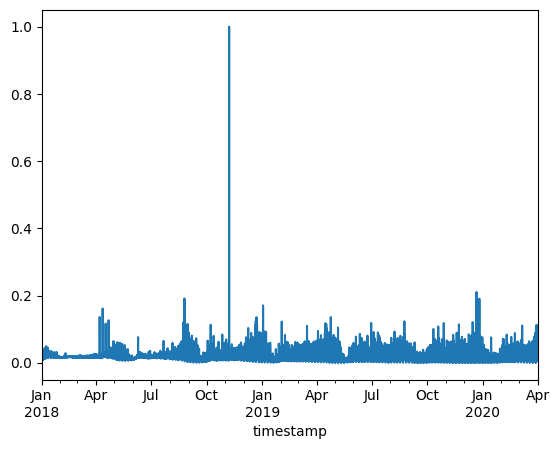

In [167]:
correlated_results['T2_South']['K703'].plot()

In [168]:
df = correlated_results['T2_South']
df

,K704,K702,K703,K159,K182,K183,K128,K139,K104,K101,K206,K074,K414,K415,K250
timestamp,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.011258,0.011898,0.002505,0.002858,0.010404,0.009560,0.004544,0.005778,0.005649,0.007032,0.010647,0.016899,0.010030,0.013775,0.004691
2018-01-01 01:00:00,0.076445,0.079657,0.016206,0.018748,0.065424,0.070189,0.023336,0.031968,0.038146,0.043327,0.072409,0.134155,0.071183,0.104144,0.029327
2018-01-01 02:00:00,0.057710,0.080438,0.015503,0.015510,0.086780,0.040918,0.026984,0.048832,0.046607,0.033566,0.059560,0.101268,0.050919,0.070973,0.021845
2018-01-01 03:00:00,0.056902,0.036585,0.013973,0.017336,0.044783,0.038141,0.030981,0.039815,0.025574,0.022081,0.058661,0.058376,0.076319,0.084690,0.026843
2018-01-01 04:00:00,0.097412,0.049409,0.010184,0.014370,0.039405,0.074025,0.023752,0.018099,0.041703,0.027265,0.064158,0.067256,0.063662,0.096317,0.042644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:00:00,0.151111,0.097870,0.020569,0.036923,0.000432,0.122681,0.076114,0.064206,0.029215,0.053480,0.073967,0.242841,0.055988,0.057221,0.019737
2020-03-31 21:00:00,0.115182,0.178146,0.015977,0.031851,0.000421,0.141878,0.046874,0.051864,0.105848,0.056133,0.087711,0.189794,0.042219,0.155908,0.045872
2020-03-31 22:00:00,0.179660,0.159887,0.041516,0.013718,0.090540,0.170409,0.071481,0.099794,0.031281,0.035123,0.067808,0.863539,0.065784,0.186487,0.032549


In [171]:
df.dropna().corr()

,K704,K702,K703,K159,K182,K183,K128,K139,K104,K101,K206,K074,K414,K415,K250
K704,1.000000,0.249062,0.254793,0.149256,0.151761,0.189221,0.148332,0.216602,0.102411,0.211017,0.235843,0.201610,0.297029,0.275823,0.201429
K702,0.249062,1.000000,0.248213,0.177156,0.178870,0.240428,0.183494,0.070216,0.045688,0.221130,0.246860,0.226500,0.234070,0.188399,0.221908
K703,0.254793,0.248213,1.000000,0.188529,0.186624,0.223986,0.171258,0.079945,0.081901,0.203511,0.221315,0.201993,0.217543,0.177948,0.196339
K159,0.149256,0.177156,0.188529,1.000000,0.130847,0.167166,0.133108,0.037481,0.127055,0.159052,0.165462,0.159092,0.170436,0.140913,0.148223
K182,0.151761,0.178870,0.186624,0.130847,1.000000,0.222161,0.139094,-0.005551,0.013613,0.155540,0.188606,0.174552,0.184359,0.150122,0.151651
K183,0.189221,0.240428,0.223986,0.167166,0.222161,1.000000,0.207235,0.113435,0.116168,0.208340,0.236939,0.197128,0.160763,0.154076,0.169065
K128,0.148332,0.183494,0.171258,0.133108,0.139094,0.207235,1.000000,0.128699,0.094720,0.180551,0.195728,0.160656,0.134641,0.140810,0.150787
K139,0.216602,0.070216,0.079945,0.037481,-0.005551,0.113435,0.128699,1.000000,0.192631,0.089016,0.110144,0.080309,0.192271,0.088279,0.048732
K104,0.102411,0.045688,0.081901,0.127055,0.013613,0.116168,0.094720,0.192631,1.000000,0.123050,0.129601,0.132485,0.101694,0.092146,0.088885
K101,0.211017,0.221130,0.203511,0.159052,0.155540,0.208340,0.180551,0.089016,0.123050,1.000000,0.314376,0.208484,0.205058,0.195363,0.209296


In [141]:
def plot_heatmap(df, trajectory,direction):
    fig, ax = plt.subplots(facecolor='w')
    sns.heatmap(df.corr())
    plt.title(f"Correlations for {trajectory} {direction}")
    plt.xlabel('Intersection')
    plt.ylabel('Intersection')
    plt.show()
    return

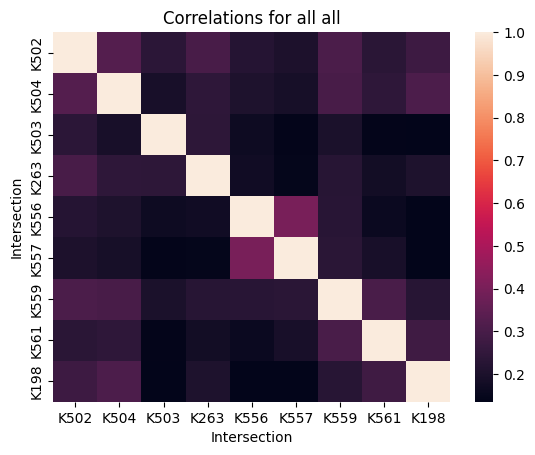

In [142]:
df = correlated_results['T1_North']
plot_heatmap(df, 'all','all')

In [143]:
correlated_results['T2_North'].corr()

,K704,K702,K703,K159,K182,K183,K128,K139,K104,K101,K206,K074,K414,K415,K250
K704,1.000000,0.327270,0.302833,0.244953,0.137534,0.276343,0.151215,0.105179,0.100711,0.263504,0.314677,0.272479,0.210917,0.257351,0.309604
K702,0.327270,1.000000,0.377465,0.193994,0.114139,0.234899,0.129556,0.059272,0.076564,0.205098,0.243528,0.234805,0.173531,0.244061,0.307645
K703,0.302833,0.377465,1.000000,0.186397,0.114925,0.239144,0.118834,0.103296,0.095815,0.229968,0.228788,0.209015,0.140838,0.198827,0.256956
K159,0.244953,0.193994,0.186397,1.000000,0.161794,0.200063,0.108275,0.247493,0.190356,0.176240,0.197012,0.216482,0.289725,0.164022,0.186694
K182,0.137534,0.114139,0.114925,0.161794,1.000000,0.127450,0.047329,0.059962,0.055559,0.113060,0.116022,0.115129,0.170001,0.109057,0.118703
K183,0.276343,0.234899,0.239144,0.200063,0.127450,1.000000,0.178724,0.134342,0.115414,0.234014,0.260667,0.246865,0.168694,0.197213,0.265331
K128,0.151215,0.129556,0.118834,0.108275,0.047329,0.178724,1.000000,0.043662,0.073893,0.129207,0.126974,0.138471,0.085540,0.116851,0.134801
K139,0.105179,0.059272,0.103296,0.247493,0.059962,0.134342,0.043662,1.000000,0.266365,0.111766,0.142199,0.132787,0.224039,0.054737,0.096782
K104,0.100711,0.076564,0.095815,0.190356,0.055559,0.115414,0.073893,0.266365,1.000000,0.110523,0.117975,0.120474,0.142782,0.051740,0.078070
K101,0.263504,0.205098,0.229968,0.176240,0.113060,0.234014,0.129207,0.111766,0.110523,1.000000,0.289793,0.216078,0.169818,0.191395,0.226983


T1 North


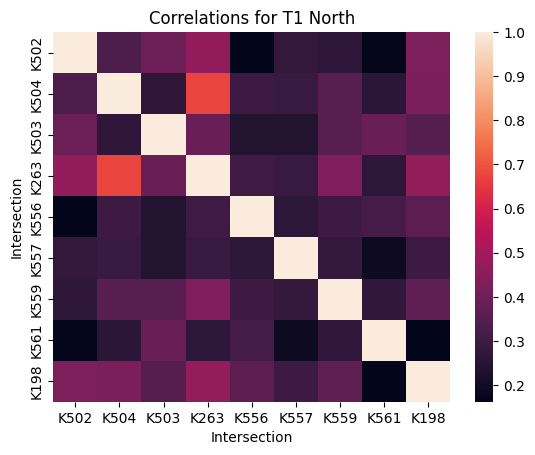

T1 South


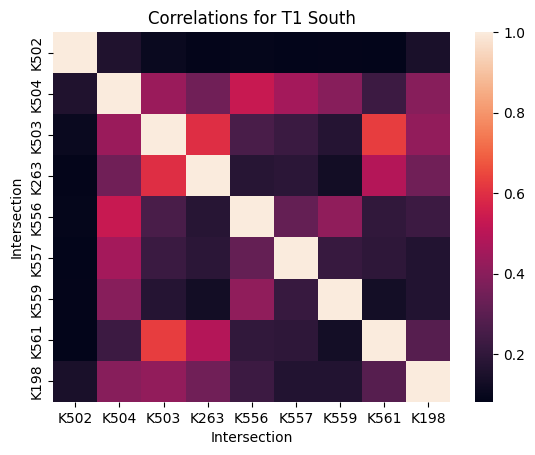

T2 South


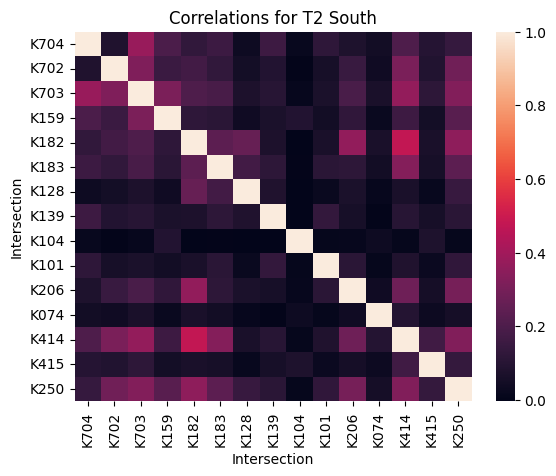

T2 North


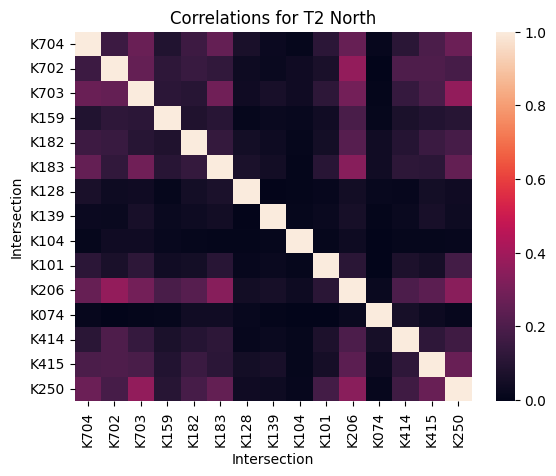

In [67]:
df = correlated_results['df']
plot_heatmap(df, 'all','all')

In [68]:
# for trajectory in correlated_results.keys():
#     for direction in correlated_results[trajectory].keys():
#         print(trajectory,direction)
#         df = correlated_results[trajectory][direction]
#         plot_heatmap(df, trajectory,direction)

In [103]:
correlated_results['df'].corr()

,717508,772151,767366,769405,769388,716951,717497,717483,717468,772596,...,773916,767750,717504,717510,716949,717458,717465,717459,716960,769346
717508,1.000000,0.698464,0.671492,0.477197,0.626261,0.601593,0.687661,0.600036,0.686771,0.678864,...,0.649258,0.659261,0.880491,0.616648,0.624041,0.689288,0.667120,0.666434,0.617733,0.682333
772151,0.698464,1.000000,0.930730,0.506301,0.852705,0.818034,0.976920,0.872522,0.953684,0.984595,...,0.879022,0.952377,0.820935,0.586515,0.827386,0.976014,0.970202,0.972706,0.811265,0.978174
767366,0.671492,0.930730,1.000000,0.517400,0.809607,0.798640,0.916571,0.820018,0.919474,0.924598,...,0.811738,0.908861,0.755312,0.549558,0.807887,0.922759,0.905786,0.907722,0.802661,0.924460
769405,0.477197,0.506301,0.517400,1.000000,0.457958,0.437863,0.492907,0.422968,0.498301,0.488600,...,0.464862,0.488198,0.430270,0.455451,0.466788,0.501723,0.468821,0.466155,0.470285,0.492472
769388,0.626261,0.852705,0.809607,0.457958,1.000000,0.717751,0.854961,0.769097,0.850688,0.862054,...,0.773591,0.828524,0.733326,0.537099,0.720159,0.859258,0.856814,0.857482,0.703766,0.853911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717458,0.689288,0.976014,0.922759,0.501723,0.859258,0.816415,0.975962,0.873276,0.957784,0.980600,...,0.877676,0.947028,0.812700,0.589506,0.824022,1.000000,0.969406,0.970430,0.805158,0.972593
717465,0.667120,0.970202,0.905786,0.468821,0.856814,0.805371,0.975851,0.884152,0.946586,0.986606,...,0.888960,0.940763,0.809758,0.568991,0.802328,0.969406,1.000000,0.993542,0.780949,0.975486
717459,0.666434,0.972706,0.907722,0.466155,0.857482,0.806905,0.977267,0.884365,0.947330,0.988043,...,0.888028,0.942345,0.810175,0.566848,0.805369,0.970430,0.993542,1.000000,0.782208,0.977148
716960,0.617733,0.811265,0.802661,0.470285,0.703766,0.978167,0.797083,0.710706,0.793216,0.799758,...,0.713961,0.788400,0.662463,0.528620,0.985911,0.805158,0.780949,0.782208,1.000000,0.803412


In [69]:
correlated_results['T1']['North'].corr()

,K502,K504,K503,K263,K556,K557,K559,K561,K198
K502,1.000000,0.330388,0.393906,0.468859,0.164201,0.276675,0.264612,0.170635,0.428697
K504,0.330388,1.000000,0.267208,0.672784,0.298868,0.286640,0.356081,0.258757,0.423634
K503,0.393906,0.267208,1.000000,0.389323,0.239565,0.239185,0.357973,0.389136,0.351524
K263,0.468859,0.672784,0.389323,1.000000,0.302292,0.288732,0.433167,0.262109,0.472026
K556,0.164201,0.298868,0.239565,0.302292,1.000000,0.260720,0.295169,0.313673,0.363049
K557,0.276675,0.286640,0.239185,0.288732,0.260720,1.000000,0.277239,0.190483,0.297592
K559,0.264612,0.356081,0.357973,0.433167,0.295169,0.277239,1.000000,0.271980,0.369052
K561,0.170635,0.258757,0.389136,0.262109,0.313673,0.190483,0.271980,1.000000,0.162200
K198,0.428697,0.423634,0.351524,0.472026,0.363049,0.297592,0.369052,0.162200,1.000000


In [70]:
correlated_results['T1']['South'].corr()

,K502,K504,K503,K263,K556,K557,K559,K561,K198
K502,1.000000,0.160319,0.104519,0.089013,0.089573,0.082124,0.089116,0.083247,0.144638
K504,0.160319,1.000000,0.436002,0.344404,0.533099,0.456525,0.397368,0.227386,0.396208
K503,0.104519,0.436002,1.000000,0.598067,0.259850,0.223488,0.172020,0.628567,0.417026
K263,0.089013,0.344404,0.598067,1.000000,0.175571,0.188764,0.127209,0.488050,0.346470
K556,0.089573,0.533099,0.259850,0.175571,1.000000,0.320311,0.412905,0.203654,0.226295
K557,0.082124,0.456525,0.223488,0.188764,0.320311,1.000000,0.215288,0.194143,0.165961
K559,0.089116,0.397368,0.172020,0.127209,0.412905,0.215288,1.000000,0.132234,0.167818
K561,0.083247,0.227386,0.628567,0.488050,0.203654,0.194143,0.132234,1.000000,0.289702
K198,0.144638,0.396208,0.417026,0.346470,0.226295,0.165961,0.167818,0.289702,1.000000


In [71]:
correlated_results['T2']['North'].corr()

,K704,K702,K703,K159,K182,K183,K128,K139,K104,K101,K206,K074,K414,K415,K250
K704,1.000000,0.155229,0.268645,0.085759,0.158785,0.258551,0.065601,0.025259,0.008340,0.110735,0.259135,0.013597,0.106315,0.193084,0.273609
K702,0.155229,1.000000,0.257214,0.118434,0.148280,0.128051,0.032536,0.020876,0.039277,0.063774,0.367152,-0.000366,0.201965,0.202563,0.184056
K703,0.268645,0.257214,1.000000,0.113733,0.100776,0.285827,0.036871,0.062828,0.037522,0.116037,0.290820,0.007408,0.139004,0.189636,0.364512
K159,0.085759,0.118434,0.113733,1.000000,0.081625,0.103540,0.008440,0.022340,0.017878,0.043218,0.189976,0.011782,0.069049,0.087685,0.099894
K182,0.158785,0.148280,0.100776,0.081625,1.000000,0.136163,0.050987,0.035285,0.008931,0.048683,0.221199,0.040924,0.097417,0.152646,0.182875
K183,0.258551,0.128051,0.285827,0.103540,0.136163,1.000000,0.069358,0.044803,0.006504,0.102202,0.337801,0.039708,0.114212,0.112670,0.251203
K128,0.065601,0.032536,0.036871,0.008440,0.050987,0.069358,1.000000,0.000997,0.007433,0.015660,0.044055,0.019213,0.014854,0.048543,0.037970
K139,0.025259,0.020876,0.062828,0.022340,0.035285,0.044803,0.000997,1.000000,0.010095,0.022840,0.057302,0.006978,0.022569,0.059449,0.033628
K104,0.008340,0.039277,0.037522,0.017878,0.008931,0.006504,0.007433,0.010095,1.000000,0.009079,0.033957,-0.000171,0.009272,0.011239,0.014129
K101,0.110735,0.063774,0.116037,0.043218,0.048683,0.102202,0.015660,0.022840,0.009079,1.000000,0.109053,-0.003780,0.072398,0.054424,0.176306


In [72]:
correlated_results['T2']['South'].corr()

,K704,K702,K703,K159,K182,K183,K128,K139,K104,K101,K206,K074,K414,K415,K250
K704,1.000000,0.080914,0.377122,0.195648,0.129686,0.156704,0.035339,0.157665,0.017593,0.118673,0.077359,0.045661,0.202996,0.096787,0.140300
K702,0.080914,1.000000,0.318515,0.152082,0.172597,0.127017,0.051374,0.089854,0.001313,0.058679,0.146751,0.038679,0.309936,0.086394,0.283209
K703,0.377122,0.318515,1.000000,0.312464,0.203650,0.184960,0.074594,0.099639,0.012568,0.069919,0.189128,0.063535,0.365582,0.114896,0.327168
K159,0.195648,0.152082,0.312464,1.000000,0.121338,0.107533,0.035976,0.069553,0.089621,0.046238,0.122585,0.022304,0.159746,0.048327,0.224529
K182,0.129686,0.172597,0.203650,0.121338,1.000000,0.237093,0.260998,0.073845,-0.003390,0.063526,0.363527,0.065137,0.475723,0.064124,0.354972
K183,0.156704,0.127017,0.184960,0.107533,0.237093,1.000000,0.169980,0.116212,0.001708,0.106555,0.116830,0.045251,0.332855,0.055409,0.237509
K128,0.035339,0.051374,0.074594,0.035976,0.260998,0.169980,1.000000,0.080001,-0.003487,0.022181,0.068223,0.012285,0.066089,0.016483,0.143365
K139,0.157665,0.089854,0.099639,0.069553,0.073845,0.116212,0.080001,1.000000,-0.000082,0.133639,0.055908,0.000448,0.100441,0.056944,0.107725
K104,0.017593,0.001313,0.012568,0.089621,-0.003390,0.001708,-0.003487,-0.000082,1.000000,0.010170,0.013232,0.034879,0.010972,0.076885,0.010140
K101,0.118673,0.058679,0.069919,0.046238,0.063526,0.106555,0.022181,0.133639,0.010170,1.000000,0.107924,0.011261,0.079712,0.026433,0.123160


In [58]:
correlated_results

{'T1': {'North':                          K502      K504      K503      K263      K556  \
  timestamp                                                               
  2018-01-01 01:00:00  0.581552  0.924355  0.678917  0.580323  1.011816   
  2018-01-01 02:00:00  0.833481  0.768982  1.088581  0.875307  0.737809   
  2018-01-01 03:00:00  0.837261  0.869662  0.975351  0.902531  0.863356   
  2018-01-01 04:00:00  1.039092  0.850385  0.950976  0.897559  0.987289   
  2018-01-01 05:00:00  1.048851  0.862610  0.931401  0.867656  0.795293   
  ...                       ...       ...       ...       ...       ...   
  2020-03-30 20:00:00  1.037163  0.978769  0.983110  0.970669  1.091025   
  2020-03-30 21:00:00  0.976095  1.034538  0.977496  0.942143  1.005997   
  2020-03-30 22:00:00  0.943266  0.946115  0.950829  0.866231  1.111294   
  2020-03-30 23:00:00  1.148283  1.131940  1.045876  1.053690  1.050337   
  2020-03-31 00:00:00  1.079130  1.240889  0.902702  0.856872  0.869401   
  
       

In [59]:
with open('../data/OBIS_results.pickle', 'rb') as f:
    results = pickle.load(f)

In [60]:
results['T1']['North']['lof_df']

,K502,K504,K503,K263,K556,K557,K559,K561,K198
timestamp,,,,,,,,,
2018-01-01 00:00:00,1.135469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,0.983539,0.986246,0.961889,0.966621,0.979518,0.970879,0.974482,0.954100,0.945818
2018-01-01 02:00:00,1.004457,0.987169,0.949001,1.018715,0.942231,0.993697,0.954347,0.967616,0.937242
2018-01-01 03:00:00,0.999542,1.055629,1.000696,0.999394,0.995447,0.980556,0.978262,0.980209,1.013693
2018-01-01 04:00:00,0.993540,1.611556,1.013545,1.073884,1.079002,0.990713,0.995898,0.986004,0.991805
...,...,...,...,...,...,...,...,...,...
2020-03-31 19:00:00,1.214469,6.679295,1.526070,1.295858,1.019057,0.968667,1.750148,0.996713,1.446675
2020-03-31 20:00:00,0.943426,0.969221,0.961866,0.974532,1.166357,0.978887,1.617988,1.334510,2.221066
2020-03-31 21:00:00,1.104595,1.027644,0.985285,2.075074,1.259547,2.460222,0.982032,0.964793,0.983727


In [65]:
correlated_results = {}
# for each trajectory, direction and intersection, run AE model
for trajectory in config['trajectories']:
    correlated_results[trajectory] = {}
    for direction in config['trajectories'][trajectory]:
        print(trajectory, direction)
        lof_df = results[trajectory][direction]['lof_df']
        # save the results
        correlated_results[trajectory][direction]= lof_df

T1 North
T1 South
T2 South
T2 North


In [66]:
correlated_results

{'T1': {'North':                          K502      K504      K503      K263      K556  \
  timestamp                                                               
  2018-01-01 00:00:00  1.135469       NaN       NaN       NaN       NaN   
  2018-01-01 01:00:00  0.983539  0.986246  0.961889  0.966621  0.979518   
  2018-01-01 02:00:00  1.004457  0.987169  0.949001  1.018715  0.942231   
  2018-01-01 03:00:00  0.999542  1.055629  1.000696  0.999394  0.995447   
  2018-01-01 04:00:00  0.993540  1.611556  1.013545  1.073884  1.079002   
  ...                       ...       ...       ...       ...       ...   
  2020-03-31 19:00:00  1.214469  6.679295  1.526070  1.295858  1.019057   
  2020-03-31 20:00:00  0.943426  0.969221  0.961866  0.974532  1.166357   
  2020-03-31 21:00:00  1.104595  1.027644  0.985285  2.075074  1.259547   
  2020-03-31 22:00:00  1.326210  5.955487  0.992394  0.972964  1.020318   
  2020-03-31 23:00:00  1.484159  0.970803  1.010712  1.071178  1.268897   
  
       